In [1]:
import torch
#import lattice
from torch.utils.cpp_extension import load
lattice = load(name="lattice",sources=["lattice.cpp"])
import glob

In [2]:
from crf.gaussian_matrix import LatticeGaussian#, LSHGaussian
from crf.crf import *
from crf.depth import *

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
def read_img(filename):
    img = Image.open(filename).convert('RGB')
    img = np.array(img).astype(float)/255
    return img

In [5]:
paths = glob.glob('./images/*.bmp')
print(paths)

['./images/bilateral_out_2.bmp', './images/output.bmp', './images/filtered_grey.bmp', './images/input.bmp', './images/bilateral_out_1.bmp', './images/gray_original.bmp', './images/small_input.bmp']


In [6]:
img = read_img('./images/input.bmp')[::12,::12]
filtered_img = read_img('./images/bilateral_out_1.bmp')[::12,::12]
sigma_p = .01
sigma_c = .125

In [7]:
h,w,c = img.shape
position = np.mgrid[:h,:w].transpose((1,2,0))/np.sqrt(h**2+w**2)
reference = np.zeros((h,w,5))
reference[...,:3] = img/sigma_c
reference[...,3:] = position/sigma_p
#reference = position/sigma_p
homo_src = np.ones((h,w,3+1))
homo_src[...,:c] = img

In [8]:
ref_arr = torch.from_numpy(reference.reshape((h*w,-1)).astype(np.float32))
W = LatticeGaussian(ref_arr)
W2 = gaussian_weights_u(ref_arr)#
src_arr = torch.from_numpy(homo_src.reshape((h*w,-1)).astype(np.float32))

In [9]:
out = (W@src_arr+src_arr)#/(1+2**(-3))
a = out[:,:3]#/(out[:,-1][:,None])

In [10]:
out2 = W2@src_arr+src_arr
b = out2[:,:3]#/(out2[:,-1][:,None])

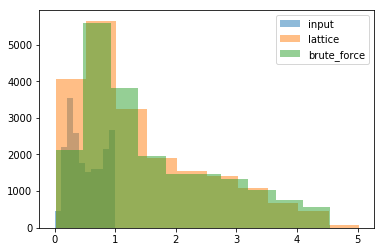

In [11]:
plt.hist(src_arr[:,:3].contiguous().view(-1).numpy(),alpha=.5)
plt.hist(a.contiguous().view(-1).numpy(),alpha=.5)
plt.hist(b.contiguous().view(-1).numpy(),alpha=.5)
plt.legend(["input","lattice","brute_force"])

In [12]:
#b = lattice.filter(src_arr,ref_arr)
#a = b[:,:3]#/(b[:,-1][:,None])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


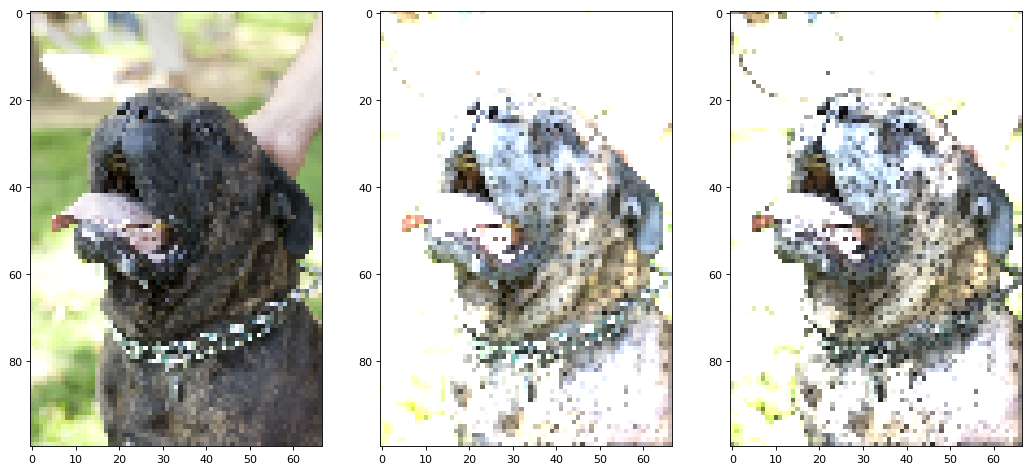

In [13]:
f,axes = plt.subplots(1,3,figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
axes[0].imshow(img)
axes[1].imshow(b[:,:3].numpy().reshape((h,w,c)))
axes[2].imshow(a[:,:3].numpy().reshape((h,w,c)))
#axes[2].imshow(filtered_img)
plt.show()

In [ ]:
%timeit lattice.filter(src_arr,ref_arr)